<a href="https://colab.research.google.com/github/Chavelanda/Airbnb-Bayesian-Network/blob/main/airbnb_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Network: Airbnb houses in Bologna

**Students enrolled in academic year 2021/2022**

Alessandro Lombardini - 0001033317

Giacomo Melacini - 0001034542
## Installing and importing and required libraries

In [ ]:
!pip install pgmpy==0.1.19

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD, State
from pgmpy.inference import VariableElimination, ApproxInference
from pgmpy.estimators import HillClimbSearch
from pgmpy.sampling import BayesianModelSampling, GibbsSampling
from pgmpy.base import DAG

import networkx as nx
import matplotlib.pyplot as plt

print('Libraries imported')

Libraries imported


## Introduction
This is the project for the course *Fundamentals of Artificial Intelligence and Knowledge Representation - Module 3* of the Master in Artificial Intelligence of the University of Bologna.

The aim of this project is to build a small Bayesian Network related to Airbnb houses in Bologna. The network will be constructed starting from the database publicly available on the [open data website](https://opendata.comune.bologna.it/explore/dataset/bologna-rilevazione-airbnb/information/?disjunctive.neighbourhood&disjunctive.room_type) of *Comune di Bologna*. The network will be a probabilistic model for the Airbnb housing situation in Bologna and can be used to explore the phenomenon and derive useful insights about it.

The use cases for such a network are multiples and go from the owner of an Airbnb house deciding the best price to rent it, to checking whether a house with given features is common in a neighbourhood. It could also be used by Airbnb to discover improbable (i.e. fake) announcements or to understant which part of the city is more adapt to which client and therefore enhance the experience of the user.

Here follows a short summary of the project:
1. [Preprocessing](#scrollTo=IvSbtrrzxgWV&line=1&uniqifier=1)
2. [Structure learning](#scrollTo=xytny2X9xgWc)
3. [Network creation](#scrollTo=Qmh1K1YmxgWf)
4. [Inference](#scrollTo=4ggIXsuLxgWg&line=1&uniqifier=1)
5. [Final remarks](#scrollTo=mdwmnBolVk_6&line=2&uniqifier=1)


## Preprocessing
The preprocessing section will be structured as follows: 
1. First the Airbnb database will be downloaded and explored
2. The relevant columns for the construction of the network will be selected
3. The selected features will be preprocessed in order to be used in the network

### Loading and exploring the database


In [ ]:
db_url = 'https://raw.githubusercontent.com/Chavelanda/Airbnb-Bayesian-Network/main/listings.csv'
listings = pd.read_csv(db_url)
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42196,https://www.airbnb.com/rooms/42196,20211217003510,2021-12-17,50 sm Studio in the historic centre,<b>The space</b><br />Really cozy and typical ...,NaN,https://a0.muscache.com/pictures/4775726/68044...,184487,https://www.airbnb.com/users/show/184487,...,4.85,4.85,4.70,NaN,t,1,1,0,0,1.32
1,46352,https://www.airbnb.com/rooms/46352,20211217003510,2021-12-17,A room in Pasolini's house,"Simple, cozy and silent room in a lived house ...",In the very nearby you have Via Saragozza whic...,https://a0.muscache.com/pictures/9f94acc3-98fc...,467810,https://www.airbnb.com/users/show/467810,...,4.79,4.80,4.59,NaN,f,2,0,2,0,2.20
2,59697,https://www.airbnb.com/rooms/59697,20211217003510,2021-12-17,COZY LARGE BEDROOM in the city center,"Cozy, spacious and bright double bedroom, in a...",NaN,https://a0.muscache.com/pictures/ac0528c4-b26f...,286688,https://www.airbnb.com/users/show/286688,...,4.79,4.82,4.66,NaN,f,2,0,2,0,2.18
3,85368,https://www.airbnb.com/rooms/85368,20211217003510,2021-12-17,Garden House Bologna,<b>The space</b><br />Garden House Bologna let...,NaN,https://a0.muscache.com/pictures/585815/331d45...,467675,https://www.airbnb.com/users/show/467675,...,5.00,4.74,4.82,NaN,f,1,1,0,0,0.34
4,145779,https://www.airbnb.com/rooms/145779,20211217003510,2021-12-17,SINGLE ROOM,<b>The space</b><br />&lt;3,NaN,https://a0.muscache.com/pictures/76537876/27c6...,705535,https://www.airbnb.com/users/show/705535,...,4.92,5.00,4.86,NaN,f,9,2,7,0,0.55


As it can be seen, the database has many features (74) that are used to describe each apartment. There are pictures, descriptions, reviews, place description, apartment features, amenities and so on. Not all of them are useful in the construction of the network and, because of the size of this project, only the most relevant ones will be taken into consideration.

In this case, the features that are taken into consideration are the following:
1. Amenities
2. Neighbourhood
3. Room type
4. Accommodates
5. Bathrooms
6. Price 

In our opinion they are the most useful one to characterize an Airbnb offer and are the ones that are normally looked at by a user when browsing through the website.

It follows the database with the filtered columns.

In [ ]:
features = ['amenities', 'neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms_text', 'price']
listings.loc[:, features].head(3)


,amenities,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,price
0,"[""Wifi"", ""Private entrance"", ""Kitchen"", ""Iron""...",Santo Stefano,Entire home/apt,2,1 bath,$68.00
1,"[""Wifi"", ""Hot water kettle"", ""Dining table"", ""...",Porto - Saragozza,Private room,2,1 shared bath,$29.00
2,"[""Wifi"", ""Dining table"", ""Bidet"", ""Kitchen"", ""...",Santo Stefano,Private room,2,1 shared bath,$50.00


Now, for each feature, it is shown a description and, if necessary, the related preprocessing activity.

### Amenities

Amenities are represented as a list of comforts that each apartment has. In order to be used in a network, they have to be converted into a one-hot array. Each amenity would then become a feature of which we know if it is present (encoded as *True*) or absent (encoded as *False*). 

In this way there would be a network node for each amenity, but since the network shall be kept small, only the most relevant ones have been considered. The presence of a kitchen and the presence of wifi connection will be considered so in this project.

In [ ]:
listings = pd.concat([listings, listings['amenities'].str.get_dummies(sep='", "').astype(bool)[['Kitchen', 'Wifi']]], axis=1)
listings = listings.rename(columns = {'Kitchen': 'kitchen', 'Wifi': 'wifi'})

In [ ]:
features = ['neighbourhood_cleansed', 'room_type', 'accommodates', 'bathrooms_text', 'price', 'kitchen', 'wifi']
listings_selection = listings.loc[:, features]
listings_selection.head(3)

,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,2,1 bath,$68.00,True,False
1,Porto - Saragozza,Private room,2,1 shared bath,$29.00,True,False
2,Santo Stefano,Private room,2,1 shared bath,$50.00,True,False


### Neighbourhood
The feature *neighbourhood_cleansed* is a string that represents the neighbourhood in which the apartment is located. It does not require any preprocessing.
It follows the list of all possible neighbourhoods.

In [ ]:
listings_selection['neighbourhood_cleansed'].unique()

array(['Santo Stefano', 'Porto - Saragozza', 'Navile',
       'San Donato - San Vitale', 'Savena', 'Borgo Panigale - Reno'],
      dtype=object)

### Room type
The feature *room_type* is also a string and represents the type of room that is offered to the client. Also in this case no preprocessing is needed. The list of possible room types is the following:

In [ ]:
listings_selection['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

### Price
The feature *price* is a string representing the floating point value of the price of the Airbnb apartment. In this case there are three preprocessing tasks to make:
* First of all, the value has to be converted to float.
* Secondly, in order to have a meaningful price, we have to divide it by the number of accommodates the apartment is offering. 
* Lastly, since Bayesian Networks deal with discrete values, the feature has to be categorized. 

The chosen categories, defined following our knowledge about typical Airbnb users, are the following:
1. \$0 -> \$20
2. \$21 -> \$40
3. \$41 -> \$60
4. \>\$60

Now let's continue with the steps mentioned above.

Step 1: parsing price into float

In [ ]:
listings_selection.loc[:, 'price'] = listings_selection.loc[:, 'price'].str.replace(r'[$|,]', '', regex=True).astype(float)
listings_selection.head(3)

,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,2,1 bath,68.0,True,False
1,Porto - Saragozza,Private room,2,1 shared bath,29.0,True,False
2,Santo Stefano,Private room,2,1 shared bath,50.0,True,False


Step 2: normalize the price by the number of accommodates

In [ ]:
listings_selection.loc[:, 'price'] = listings_selection.loc[:, 'price']/listings_selection.loc[:, 'accommodates']
listings_selection.head(3)

,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,2,1 bath,34.0,True,False
1,Porto - Saragozza,Private room,2,1 shared bath,14.5,True,False
2,Santo Stefano,Private room,2,1 shared bath,25.0,True,False


Step 3: discretizing price into the four categories

In [ ]:
listings_selection['price'], bins = pd.cut(listings_selection['price'], [0, 20, 40, 60, 10000], labels=['0-20', '21-40', '41-60', '>60'], retbins=True)
listings_selection.head(3)


,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,2,1 bath,21-40,True,False
1,Porto - Saragozza,Private room,2,1 shared bath,0-20,True,False
2,Santo Stefano,Private room,2,1 shared bath,21-40,True,False


Let's see the result.

In [ ]:
listings_selection.groupby(by='price').count()

,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,kitchen,wifi
price,,,,,,
0-20,1197,1197,1197,1197,1197,1197
21-40,1654,1654,1654,1653,1654,1654
41-60,341,341,341,339,341,341
>60,261,261,261,259,261,261


### Accommodates

The feature *accommodates* is a feature that represents the number of guests that the structure can host. 

In [ ]:
acc = listings_selection['accommodates'].unique()
print(f'Possible accommodates: {acc}\nLength: {len(acc)}\nMax number of guests: {np.max(acc)}\nMin number of guests: {np.min(acc)}')


Possible accommodates: [ 2  1  4  5  3  6  9  8  7 10 13 16 12 11 15 14]
Length: 16
Max number of guests: 16
Min number of guests: 1


The number of possible hosted guests varies greatly and there are many possible values. In order to make this feature more robust and more useful it has been decided to categorize accommodates into three categories:
1. One or two people:      1 - 2
2. Three or four people:   3 - 4
3. More than four people:  5+

These categories have been selected because, in our opinion, they are representative of the most frequent type of travelling groups.

In [ ]:
listings_selection['accommodates'], bins = pd.cut(listings_selection['accommodates'], [0, 2, 4, 10000], labels=['1-2', '3-4', '5+'], retbins=True)
listings_selection.head(3)


,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,1-2,1 bath,21-40,True,False
1,Porto - Saragozza,Private room,1-2,1 shared bath,0-20,True,False
2,Santo Stefano,Private room,1-2,1 shared bath,21-40,True,False


### Bathrooms
The feature *bathrooms_text* is a string that shows how many bathrooms there are and if they are shared.

In [ ]:
listings_selection['bathrooms_text'].unique()

array(['1 bath', '1 shared bath', '2 baths', '1.5 baths',
       '1 private bath', '2.5 baths', '3 baths', nan, '1.5 shared baths',
       '0 baths', '2 shared baths', 'Half-bath', 'Private half-bath',
       '0 shared baths', '3.5 baths', '6.5 baths', '5 baths', '4 baths',
       '3 shared baths', '6 baths', '7 baths', '10 baths', '8.5 baths',
       '10.5 baths'], dtype=object)

By looking at all the possible values for *bathrooms_text*, it has been decided that the most interesting thing was to know whether the bathroom was shared or private. By searching for the presence of the keyword *shared*, each *bathrooms_text* has been converted into a new feature *shared_bathroom* that has value *True* when the bathroom is shared and *False* otherwise.

In [ ]:
listings_selection.loc[:, 'bathrooms_text'] = listings_selection.loc[:, 'bathrooms_text'].str.contains('shared')
listings_selection = listings_selection.rename(columns = {'bathrooms_text': 'shared_bathroom'})
listings_selection.head(3)

,neighbourhood_cleansed,room_type,accommodates,shared_bathroom,price,kitchen,wifi
0,Santo Stefano,Entire home/apt,1-2,False,21-40,True,False
1,Porto - Saragozza,Private room,1-2,True,0-20,True,False
2,Santo Stefano,Private room,1-2,True,21-40,True,False


### Removing apartments with incomplete information 
The last preprocessing action has been the removal of incomplete entries.

In [ ]:
print(f'Number of rows before cleaning: {listings_selection.shape[0]}')
listings_cleaned = listings_selection.dropna()
print(f'Number of rows after cleaning: {listings_cleaned.shape[0]}')


Number of rows before cleaning: 3453
Number of rows after cleaning: 3448


## Structure learning
After cleaning the Airbnb database, the next step is to try to understand which is the structure of the network that connects the nodes formed by the features of the database itself. 

Remembering that the edges of the network should go from a cause to a direct effect, the learning is started by trying to figure out which are the causal relations among the features. Since we did not have the possibility to involve an Airbnb expert, we used our own expertise to build the network. In order to make the result sounder, the "expert made" network will be compared to the one built by running an HillClimb algorithm over the data. Afterwards, by iterative approximations, the network will be adjusted in order to fit the causal principle that should drive a Bayesian Network.

Here follows an image of the network built using our own expertise:

![](https://drive.google.com/uc?export=view&id=1rTf7BiThG67zu4a7I-5b7HW48EfG9Qkx)

As it can be seen, the price is the effect of all the other features. The room type is the cause of the different structural features that characterize an apartment. The neighbourhood is a cause of the room type because we can expect to find a different distribution in the kind of rooms depending on the area of the city in which these rooms are located.


#### Approximation 1
It is now run a first version of the network using the HillClimb algorithm.

  0%|          | 0/1000000 [00:00<?, ?it/s]

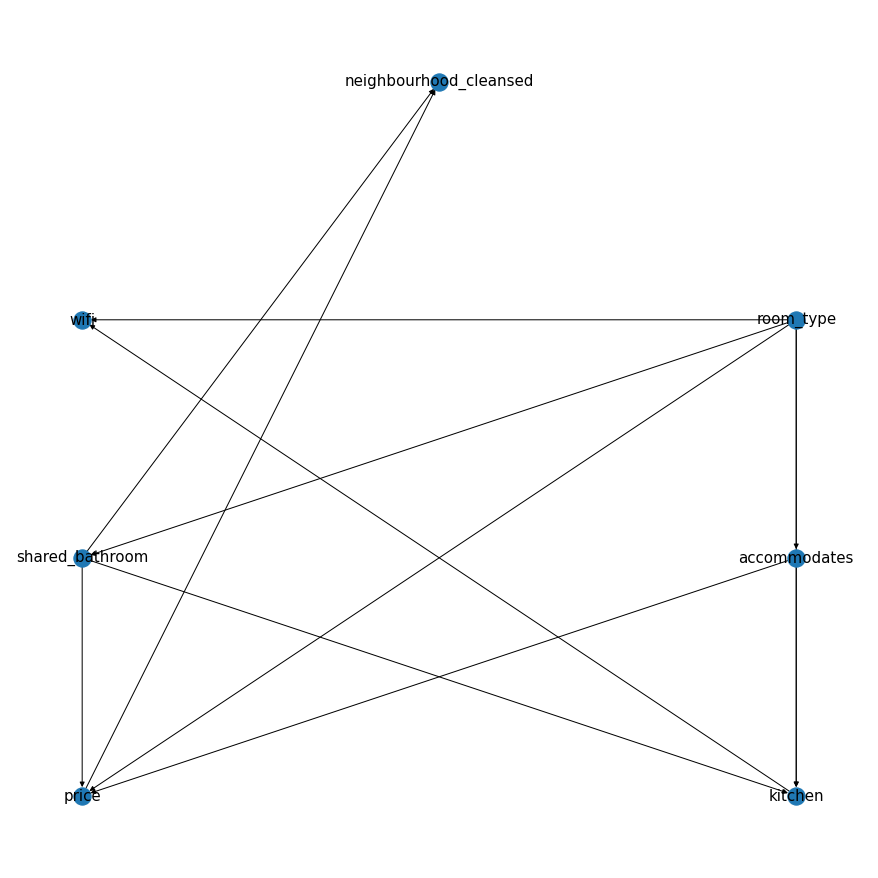

In [ ]:
c = HillClimbSearch(data=listings_cleaned)
model = c.estimate()

G = nx.DiGraph()
G.add_node('neighbourhood_cleansed', subset=3)
G.add_node('room_type', subset=2)
G.add_node('wifi', subset=2)
G.add_node('accommodates', subset=1)
G.add_node('shared_bathroom', subset=1)
G.add_node('kitchen', subset=0)
G.add_node('price', subset=0)
G.add_edges_from(model.edges())

plt.figure(1,figsize=(12,12))
pos = nx.multipartite_layout(G, scale=2, align='horizontal')
nx.draw(G, pos, with_labels=True, font_size=15)
plt.show()

This network is similar to the one designed by us with respect to the edges that connect the room type to the structural features of the apartment and to the price. Still, there are some criticalities that must be corrected:
1. The causality going in the direction *price --> neighbourhood* does not make much sense. The price is probably caused by the neighbourhood in which the apartment is located and not the opposite.
2. We did not find very accurate the presence of an edge between kitchen and wifi because, in our opinion, these two features should not be one the direct cause of the other.
3. We found that the relation *shared_bathroom --> neighbourhood* was also not appropriate in terms of causal relationship.

Therefore, the actions taken in order to solve these problems are the following:
1. Ban the edge *price --> neighbourhood*.
2. Ban the edge *kitchen --> wifi* and *wifi --> kitchen*.
3. Ban the edge *shared_bathroom --> neighbourhood*

We proceed now with another run of the HillClimb algorithm 

#### Approximation 2


  0%|          | 0/1000000 [00:00<?, ?it/s]

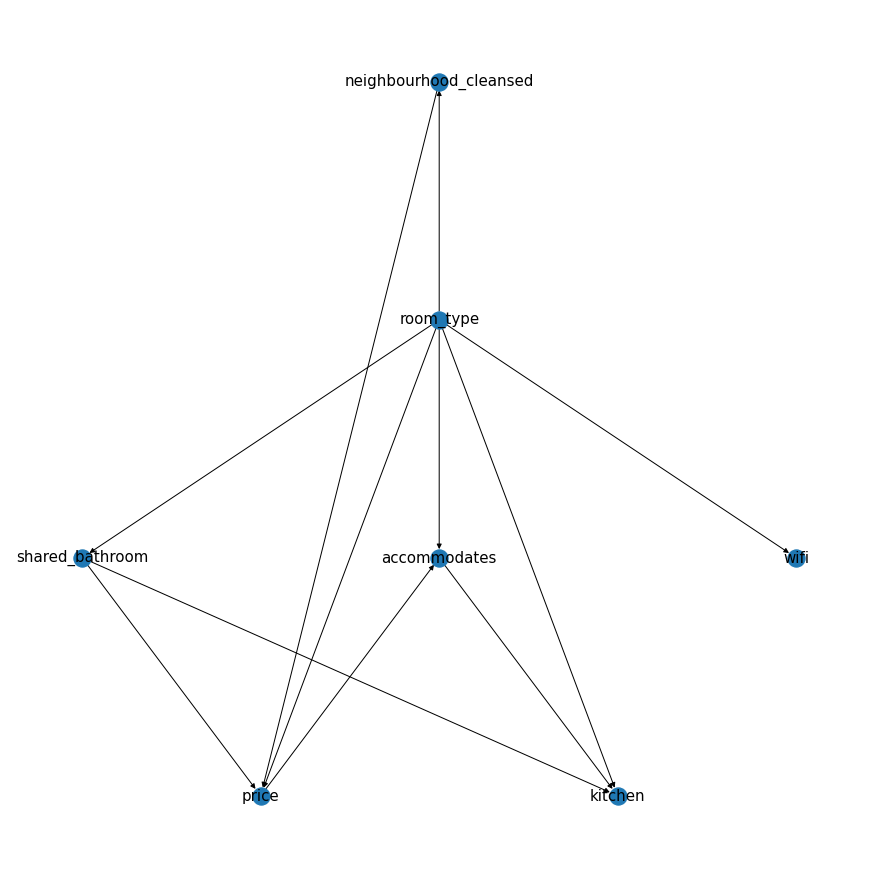

In [ ]:
model2 = c.estimate(black_list=[('kitchen', 'wifi'), ('wifi', 'kitchen'), ('price', 'neighbourhood_cleansed'), ('shared_bathroom', 'neighbourhood_cleansed')])

G = nx.DiGraph()
G.add_node('room_type', subset=2)
G.add_node('wifi', subset=1)
G.add_node('accommodates', subset=1)
G.add_node('shared_bathroom', subset=1)
G.add_node('neighbourhood_cleansed', subset=3)
G.add_node('kitchen', subset=0)
G.add_node('price', subset=0)
G.add_edges_from(model2.edges())

plt.figure(1,figsize=(12,12))
pos = nx.multipartite_layout(G, scale=2, align='horizontal')
nx.draw(G, pos, with_labels=True, font_size=15)
plt.show()

In this second approximation some of the problems that were present in the previous one have been solved, but new ones have arised:
1. There is a causal relationship problem in the edge *price --> accommodates*. The price is probably caused by the accommodates, and not the opposite.
2. There is a causal relationship problem in the edge *room_type --> neighbourhood*. It is not appropriate in terms of causal relationship.

Also in this case the action taken is to ban the edges that we considered wrong.
We proceed with another approximation.

#### Approximation 3

  0%|          | 0/1000000 [00:00<?, ?it/s]

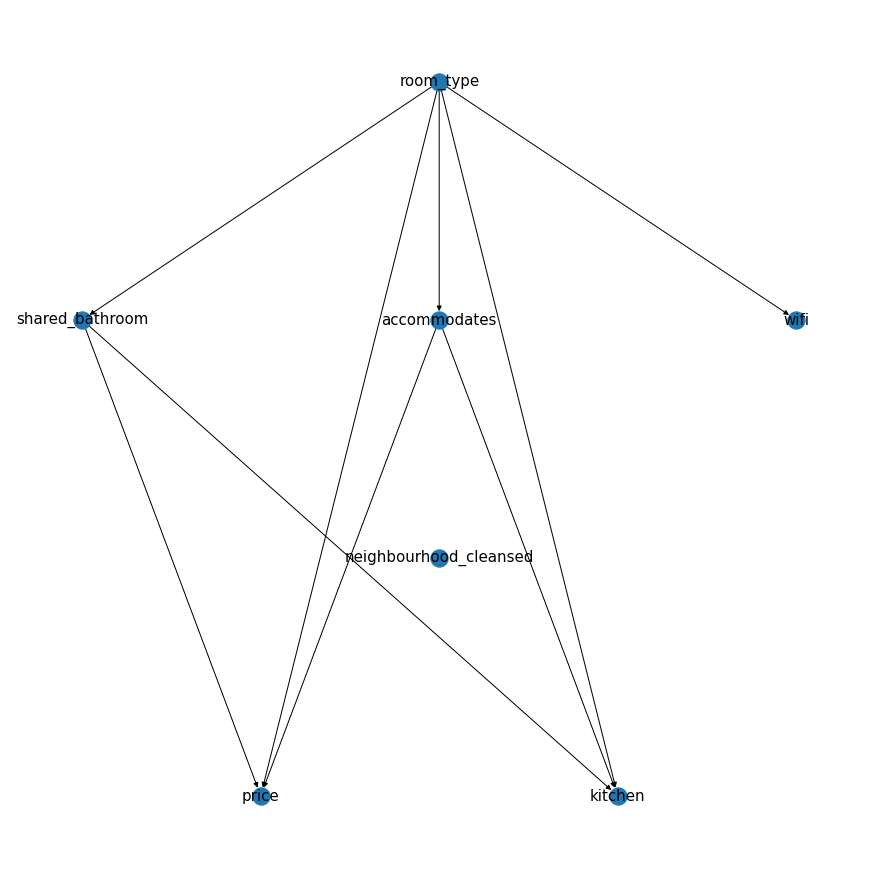

In [ ]:
model3 = c.estimate(black_list=[('kitchen', 'wifi'), ('wifi', 'kitchen'), ('price', 'neighbourhood_cleansed'), ('price', 'accommodates'), ('shared_bathroom', 'neighbourhood_cleansed'), ('room_type', 'neighbourhood_cleansed')])

G = nx.DiGraph()
G.add_node('room_type', subset=3)
G.add_node('wifi', subset=2)
G.add_node('accommodates', subset=2)
G.add_node('shared_bathroom', subset=2)
G.add_node('neighbourhood_cleansed', subset=1)
G.add_node('kitchen', subset=0)
G.add_node('price', subset=0)
G.add_edges_from(model3.edges())

plt.figure(1,figsize=(12,12))
pos = nx.multipartite_layout(G, scale=2, align='horizontal')
nx.draw(G, pos, with_labels=True, font_size=15)
plt.show()

In this third approximation we ended up with a network that is almost good. 
A difference in this approximation w.r.t. the previous one is that there is no edge connecting the neighbourhood feature. All the edges make sense in the domain of Airbnb apartments and the causality relation expressed by the direction of the edges is also understandable.

Still, we decided that the *neighbourhood* feature was interesting and worth to be reconnected to the network. In order to do it in a meaningful way, we connected it using our own structure approximation.

In [ ]:
model3.add_edges_from([('neighbourhood_cleansed', 'price'), ('neighbourhood_cleansed', 'room_type')])

Thus, the final network is the following:

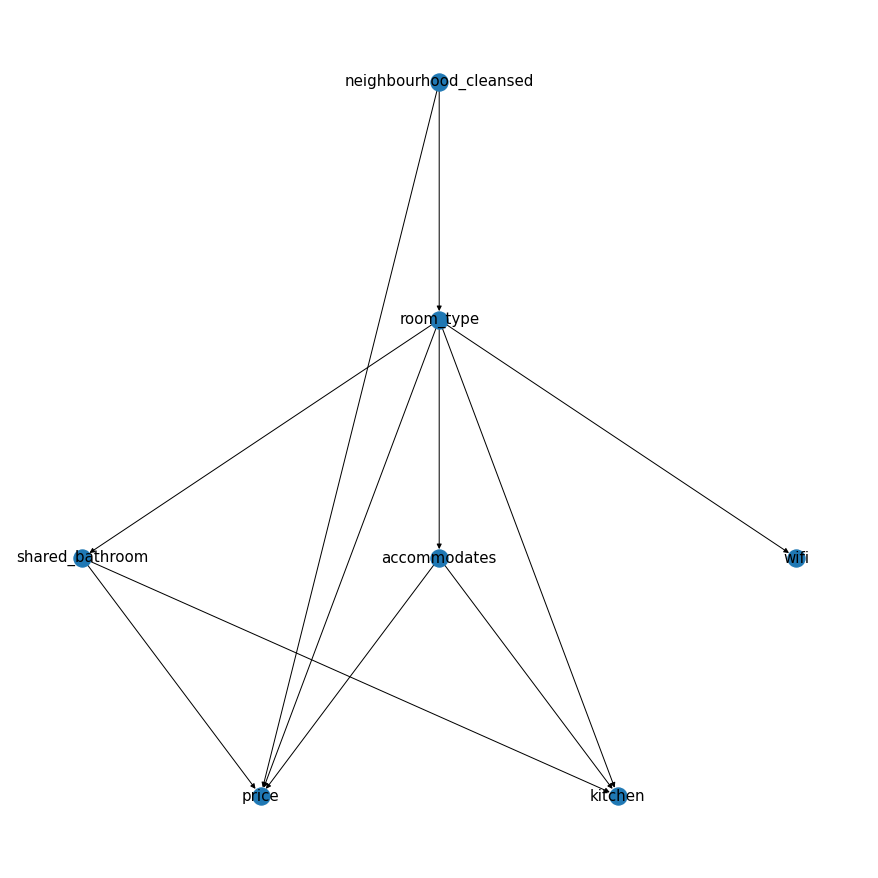

In [ ]:
G = nx.DiGraph()
G.add_node('neighbourhood_cleansed', subset=3)
G.add_node('room_type', subset=2)
G.add_node('wifi', subset=1)
G.add_node('accommodates', subset=1)
G.add_node('shared_bathroom', subset=1)
G.add_node('kitchen', subset=0)
G.add_node('price', subset=0)
G.add_edges_from(model3.edges())

plt.figure(1,figsize=(12,12))
pos = nx.multipartite_layout(G, scale=2, align='horizontal')
nx.draw(G, pos, with_labels=True, font_size=15)
plt.show()

## Network creation
The next step is to use the structure of the network that has been learned in the previous section to build the actual Bayesian network using the *pgmpy* library. Then, the model will be fit using the data from the cleaned dataset. This means that all the CPDs will be created according to the actual data.

In [ ]:
network = BayesianNetwork(model3.edges())
network.fit(listings_cleaned)
network.check_model()

True

Lets have a look at the CPDs:

In [ ]:
cpds = network.get_cpds()
for idx, cpd in enumerate(cpds):
    print(cpd.variable)
    print(f'{cpd}\n\n')

neighbourhood_cleansed
+-------------------------------------------------+-----------+
| neighbourhood_cleansed(Borgo Panigale - Reno)   | 0.0423434 |
+-------------------------------------------------+-----------+
| neighbourhood_cleansed(Navile)                  | 0.116879  |
+-------------------------------------------------+-----------+
| neighbourhood_cleansed(Porto - Saragozza)       | 0.337877  |
+-------------------------------------------------+-----------+
| neighbourhood_cleansed(San Donato - San Vitale) | 0.12152   |
+-------------------------------------------------+-----------+
| neighbourhood_cleansed(Santo Stefano)           | 0.345998  |
+-------------------------------------------------+-----------+
| neighbourhood_cleansed(Savena)                  | 0.0353828 |
+-------------------------------------------------+-----------+


price
+------------------------+-----+--------------------------------+
| accommodates           | ... | accommodates(5+)               |
+----

As it can be noticed, each CPD is conditioned on the parents of the relevant node.

The model is finally complete and fit: it can now be used to make inference.

## Inference
In this section differend kind of inferences techniques will be explored, both exact and approximate.
### Exact Inference - Variable Elimination
The first inference technique that is looked into is exact inference. Queries can have different semantic meanings. They could show probabilities of causes of a given effect or they could try to understand which is the effect of a known cause.
#### Causal
We start with a simple example to show how the probability of the price being in some ranges changes given some evidence.


We first check which is the probability distribution of *price*.

In [ ]:
exact_infer = VariableElimination(network)
q = exact_infer.query(['price'])
print(q)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+--------------+
| price        |   phi(price) |
+==============+==============+
| price(0-20)  |       0.3445 |
+--------------+--------------+
| price(21-40) |       0.4808 |
+--------------+--------------+
| price(41-60) |       0.0993 |
+--------------+--------------+
| price(>60)   |       0.0754 |
+--------------+--------------+


An Airbnb host could try to guess the price of a house given some features of it. For instance, it could try to see how the distribution of the probability of price changes knowing that there is or isn't the kitchen: we want to compare the price probability distributions when the apartment has a kitchen w.r.t. when it has not one.

In [ ]:
q = exact_infer.query(['price'], evidence={'kitchen':1}) #present
print(f'Accommodation with kitchen\n{q}')

q = exact_infer.query(['price'], evidence={'kitchen':0}) #not present
print(f'Accommodation without kitchen\n{q}')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Accommodation with kitchen
+--------------+--------------+
| price        |   phi(price) |
+==============+==============+
| price(0-20)  |       0.3579 |
+--------------+--------------+
| price(21-40) |       0.4788 |
+--------------+--------------+
| price(41-60) |       0.0914 |
+--------------+--------------+
| price(>60)   |       0.0718 |
+--------------+--------------+


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Accommodation without kitchen
+--------------+--------------+
| price        |   phi(price) |
+==============+==============+
| price(0-20)  |       0.2802 |
+--------------+--------------+
| price(21-40) |       0.4903 |
+--------------+--------------+
| price(41-60) |       0.1370 |
+--------------+--------------+
| price(>60)   |       0.0925 |
+--------------+--------------+


The first noticeable thing is that the probabilities for the price of being in the cheapest range lowers when the apartment has the kitchen. Therefore, it is more probable for the apartment to be in an higher price range.


Now we can also test the independece between *kitchen* and *price* given evidences about *accommodates*, *shared_bathroom* and *room_type*. They should be independent because all the trails connecting them become inactive given the just written evidences.

In [ ]:
q = exact_infer.query(['price'], evidence={'kitchen': 1,            # Present 
                                           'accommodates': 1,       # 3-4
                                           'shared_bathroom': 0,    # False
                                           'room_type': 0})         # Entire home/apt
print(f'Accommodation with kitchen\n{q}')

q = exact_infer.query(['price'], evidence={'kitchen': 0,              # Not present
                                           'accommodates': 1,         # 3-4
                                           'shared_bathroom': 0,      # False
                                           'room_type': 0})           # Entire home/apt
print(f'Accommodation without kitchen\n{q}')

/usr/local/lib/python3.7/dist-packages/pgmpy/factors/discrete/DiscreteFactor.py:542: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  UserWarning,


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accommodation with kitchen
+--------------+--------------+
| price        |   phi(price) |
+==============+==============+
| price(0-20)  |       0.3934 |
+--------------+--------------+
| price(21-40) |       0.4927 |
+--------------+--------------+
| price(41-60) |       0.0483 |
+--------------+--------------+
| price(>60)   |       0.0656 |
+--------------+--------------+


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Accommodation without kitchen
+--------------+--------------+
| price        |   phi(price) |
+==============+==============+
| price(0-20)  |       0.3934 |
+--------------+--------------+
| price(21-40) |       0.4927 |
+--------------+--------------+
| price(41-60) |       0.0483 |
+--------------+--------------+
| price(>60)   |       0.0656 |
+--------------+--------------+


As expected, the two tables have the same probability distribution, i.e. price and kitchen are independent given the evidences.

#### Evidential
In this example, it is explored the probability for an entire apartment of being in a neighbourhood or in another depending on some evidences.


This kind of evidential query could be used by Airbnb to suggest a neighbourhood by knowing the kind of features that a client is looking for.

In [ ]:
prior = exact_infer.query(['neighbourhood_cleansed'])
q = exact_infer.query(['neighbourhood_cleansed'], evidence={'room_type': 0})   # Entire home/apt

print(f'Prior probability distribution of neighbourhoods: \n {prior}\n\n')
print(f'Probability distribution of neighbourhood knowing that only entire homes/apartments are considered: \n {q}')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Prior probability distribution of neighbourhoods: 
 +-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed                          |   phi(neighbourhood_cleansed) |
+=================================================+===============================+
| neighbourhood_cleansed(Borgo Panigale - Reno)   |                        0.0423 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(Navile)                  |                        0.1169 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(Porto - Saragozza)       |                        0.3379 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(San Donato - San Vitale) |                        0.1215 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed

These tables tell us that the evidence about the room type influence the distribution of houses in the different neighbourhoods.


Again, we try to show the independence between two nodes. In this case we deal with *neighbourhood_cleansed* and *accommodates* when evidence about *room_type* is given.

In [ ]:
q = exact_infer.query(['neighbourhood_cleansed'], evidence={'accommodates': 0})   # 1-2
print(q)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed                          |   phi(neighbourhood_cleansed) |
+=================================================+===============================+
| neighbourhood_cleansed(Borgo Panigale - Reno)   |                        0.0417 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(Navile)                  |                        0.1335 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(Porto - Saragozza)       |                        0.3356 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(San Donato - San Vitale) |                        0.1308 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(Santo Stefano)           |                        0

The above table shows the distribution of the houses in different neighbourhoods knowing that the number of accommodations is 1 or 2.

If we add to this the same evidence we had before about the room type, we will notice that the probability distribution will not be influenced by the number of accommodates. 

In [ ]:
q = exact_infer.query(['neighbourhood_cleansed'], evidence={'accommodates': 0,   # 1-2
                                                            'room_type': 0})     # Entire home/apt
print(q)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed                          |   phi(neighbourhood_cleansed) |
+=================================================+===============================+
| neighbourhood_cleansed(Borgo Panigale - Reno)   |                        0.0432 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(Navile)                  |                        0.1010 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(Porto - Saragozza)       |                        0.3401 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(San Donato - San Vitale) |                        0.1131 |
+-------------------------------------------------+-------------------------------+
| neighbourhood_cleansed(Santo Stefano)           |                        0

As expected, this table is identical to the one that does not take into account the number of accommodates.

#### Intercausal
We want to show the mechanism of intercausality. We start by showing the prior distribution of *shared_bathroom*. We ask ourselves how this distribution is influenced by knowing that the price range is the cheapest (evidential).

In [ ]:
prior = exact_infer.query(['shared_bathroom'])
q = exact_infer.query(['shared_bathroom'], evidence={'price': 0})   # 0-20

print(f'Prior distribution of shared bathroom:\n{prior}\n\nDistribution of shared bathroom given that the house is in 0-20$ price range\n{q}')

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Prior distribution of shared bathroom:
+------------------------+------------------------+
| shared_bathroom        |   phi(shared_bathroom) |
+========================+========================+
| shared_bathroom(False) |                 0.8669 |
+------------------------+------------------------+
| shared_bathroom(True)  |                 0.1331 |
+------------------------+------------------------+

Distribution of shared bathroom given that the house is in 0-20$ price range
+------------------------+------------------------+
| shared_bathroom        |   phi(shared_bathroom) |
+========================+========================+
| shared_bathroom(False) |                 0.8255 |
+------------------------+------------------------+
| shared_bathroom(True)  |                 0.1745 |
+------------------------+------------------------+


As we can see, the probability has increased. What if we also have evidences about the number of accommodates being greater than five? We expect that, being the price also influenced by the new evidence, the probability of the apartment having a shared bathroom will decrease.

In [ ]:
q = exact_infer.query(['shared_bathroom'], evidence={'price':0,           # 0-20
                                                     'accommodates':2})   # 5+
print(q)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+------------------------+------------------------+
| shared_bathroom        |   phi(shared_bathroom) |
+========================+========================+
| shared_bathroom(False) |                 0.9847 |
+------------------------+------------------------+
| shared_bathroom(True)  |                 0.0153 |
+------------------------+------------------------+


As expected, the probability has decreased greatly. This example has showed the intercausal relationship of two causes (*shared_bathroom* and *accommodates*) having the same effect (*price*).

### Approximate inference
In this section we will look at some techniques that are used to query information from large networks. Exact techniques, in those cases, could become very inefficient. This is why techniques like *sampling* and *rejection sampling* are used. For each one of these approximate techniques, we will look at the result obtained with a large number of samples and we will compare it to the exact technique. The results should in theory be really similar.

In [ ]:
SEED = 42

#### Sampling

We will now proceed with the simplest sampling technique to query the probability distribution of the *room_type*.

In [ ]:
approx_infer = ApproxInference(network)

q1 = approx_infer.query(['room_type'], n_samples=10000)
print(q1)

q2 = exact_infer.query(['room_type'])
print(q2)

  0%|          | 0/7 [00:00<?, ?it/s]

+----------------------------+------------------+
| room_type                  |   phi(room_type) |
+============================+==================+
| room_type(Entire home/apt) |           0.7245 |
+----------------------------+------------------+
| room_type(Hotel room)      |           0.0125 |
+----------------------------+------------------+
| room_type(Private room)    |           0.2575 |
+----------------------------+------------------+
| room_type(Shared room)     |           0.0055 |
+----------------------------+------------------+


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+----------------------------+------------------+
| room_type                  |   phi(room_type) |
+============================+==================+
| room_type(Entire home/apt) |           0.7181 |
+----------------------------+------------------+
| room_type(Hotel room)      |           0.0136 |
+----------------------------+------------------+
| room_type(Private room)    |           0.2619 |
+----------------------------+------------------+
| room_type(Shared room)     |           0.0064 |
+----------------------------+------------------+


As it can be seen, using 10000 samples the approximated probability becomes really similar to the true one.

#### Rejection sampling
We will now try to use rejection sampling to query the probability distribution of price:


In [ ]:
sampler = BayesianModelSampling(network)
sample = sampler.rejection_sample(size=10000, seed=SEED)
q1 = approx_infer.get_distribution(sample, ['price'])
print(q1)
q2 = exact_infer.query(['price'])
print(q2)


  0%|          | 0/7 [00:00<?, ?it/s]

+--------------+--------------+
| price        |   phi(price) |
+==============+==============+
| price(0-20)  |       0.3416 |
+--------------+--------------+
| price(21-40) |       0.4834 |
+--------------+--------------+
| price(41-60) |       0.1018 |
+--------------+--------------+
| price(>60)   |       0.0732 |
+--------------+--------------+


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------------+--------------+
| price        |   phi(price) |
+==============+==============+
| price(0-20)  |       0.3445 |
+--------------+--------------+
| price(21-40) |       0.4808 |
+--------------+--------------+
| price(41-60) |       0.0993 |
+--------------+--------------+
| price(>60)   |       0.0754 |
+--------------+--------------+


Also in this case we ended up having really similar probabilities between the exact and approximated distribution.

Out of curiosity, we want to try the same approximate inference using a small sample. We expect the result to be less accurate.


In [ ]:
sampler = BayesianModelSampling(network)
sample = sampler.rejection_sample(size=50, seed=SEED)
q1 = approx_infer.get_distribution(sample, ['price'])
print(q1)

  0%|          | 0/7 [00:00<?, ?it/s]

+--------------+--------------+
| price        |   phi(price) |
+==============+==============+
| price(0-20)  |       0.2800 |
+--------------+--------------+
| price(21-40) |       0.5400 |
+--------------+--------------+
| price(41-60) |       0.1400 |
+--------------+--------------+
| price(>60)   |       0.0400 |
+--------------+--------------+


The results look bad. This happens because the sample is not big enough to approximate well the real distribution. 

#### Likelyhood weighted sampling
We use now likelyhood weighted sampling to query the probability distribution of having a shared bathroom:

In [ ]:
sample = sampler.likelihood_weighted_sample(size=10000, seed=SEED)
q1 = approx_infer.get_distribution(sample, ['shared_bathroom'])
print(q1)
q2 = exact_infer.query(['shared_bathroom'])
print(q2)

  0%|          | 0/7 [00:00<?, ?it/s]

+------------------------+------------------------+
| shared_bathroom        |   phi(shared_bathroom) |
+========================+========================+
| shared_bathroom(False) |                 0.8583 |
+------------------------+------------------------+
| shared_bathroom(True)  |                 0.1417 |
+------------------------+------------------------+


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+------------------------+------------------------+
| shared_bathroom        |   phi(shared_bathroom) |
+========================+========================+
| shared_bathroom(False) |                 0.8669 |
+------------------------+------------------------+
| shared_bathroom(True)  |                 0.1331 |
+------------------------+------------------------+


Also this sampling confirms the ability of approximate inference to approximate really well the exact distribution. 



#### Gibbs sampling
Gibbs sampling obtains the samples considering only the known information from the *Markov blanket* of the queried node. The Markov blanket of a node is composed by its parents, its children and the parents of the children. This works because all the infomation outside of the Markov blanket should not influence the probability obtained from the query.

It is possible to show this with a simple example. The Markov blanket of the node *kitchen* is the following:

In [ ]:
network.get_markov_blanket('kitchen')

['shared_bathroom', 'room_type', 'accommodates']

We will now query information about the presence of the kitchen with some evidence in the Markov blanket. Then we will execute the same query adding some evidence outside of the Markov blanket. The results should be identical.

In [ ]:
q1 = exact_infer.query(['kitchen'], evidence={'room_type':2, 'shared_bathroom': 1, 'accommodates':0})
print(q1)

q2 = exact_infer.query(['kitchen'], evidence={'neighbourhood_cleansed': 0, 'room_type':2, 'shared_bathroom': 1, 'accommodates':0})
print(q2)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----------------+----------------+
| kitchen        |   phi(kitchen) |
+================+================+
| kitchen(False) |         0.3378 |
+----------------+----------------+
| kitchen(True)  |         0.6622 |
+----------------+----------------+


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----------------+----------------+
| kitchen        |   phi(kitchen) |
+================+================+
| kitchen(False) |         0.3378 |
+----------------+----------------+
| kitchen(True)  |         0.6622 |
+----------------+----------------+


## Final remarks
In this project, the opportunities that Bayesian networks can offer have been explored by means of a small network related to Airbnb apartments. It has been seen how such networks can be created from a database. It has been highlighted the importance of finding a good structure starting from domain expert knowledge and improving it iteratively using adeguate algorithms. Finally, the network has been used both for showing its utility in the Airbnb domain and for showing the capabilities and potentials of Bayesian networks.